Na aula de hoje vamos trabalhar com uma série temporal multivariada. O conjunto de dados consiste em dados mensais de variáveis meteorológicas sobre a Região Metropolitana de São Paulo, além de dados de índices meteorológicos e de uso da terra. A descrição das variáveis está na aba "readme" da planilha de dados.

Objetivo: fazer predições da temperatura do ar, considerando relações com variáveis preditoras.

# Preparando o ambiente

In [53]:
# Clonando pasta do github
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/tiagofiorini/MLinPhysics.git
    import os as os
    os.chdir('./MLinPhysics')

Cloning into 'MLinPhysics'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 89 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (89/89), 25.12 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

In [55]:
# Leitura do arquivo de dados
df = pd.read_excel('aula19_dados_serie_temporal.xlsx', sheet_name='dados')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True) # dataframe indexado pela data
df.head()

,temp,rad,press,precip,tdew,iasas,nino,saodi,urb
datetime,,,,,,,,,
1979-01-01,19.073,6.057392e+08,928.97752,162,16.438,-2.4392,-1.53,0.4808,NaN
1979-02-01,21.431,5.623097e+08,928.46201,147,18.536,-0.1843,-1.34,-0.0112,NaN
1979-03-01,19.677,5.568873e+08,930.56931,230,17.104,-2.2089,-1.16,0.3828,NaN
1979-04-01,18.155,4.413918e+08,931.61565,120,15.682,-2.1214,-1.18,0.3738,NaN
1979-05-01,17.527,3.928976e+08,931.51010,128,14.179,1.4192,-1.07,-0.0231,NaN


# Análise Exploratória

Há dados faltantes?

In [56]:
# Há dados faltantes?
# Counting NaN values in all columns
print('Número de linhas: ',len(df))
print(df.isna().sum())
print('---')
print('Há 14% de dados faltantes na variável urb (área urbana).')
print('Vamos avaliar a importância dessa variável para a predição da temperatura.')

Número de linhas:  528
temp       0
rad        0
press      0
precip     0
tdew       0
iasas      0
nino       0
saodi      0
urb       72
dtype: int64
---
Há 14% de dados faltantes na variável urb (área urbana).
Vamos avaliar a importância dessa variável para a predição da temperatura.


Distribuição das variáveis

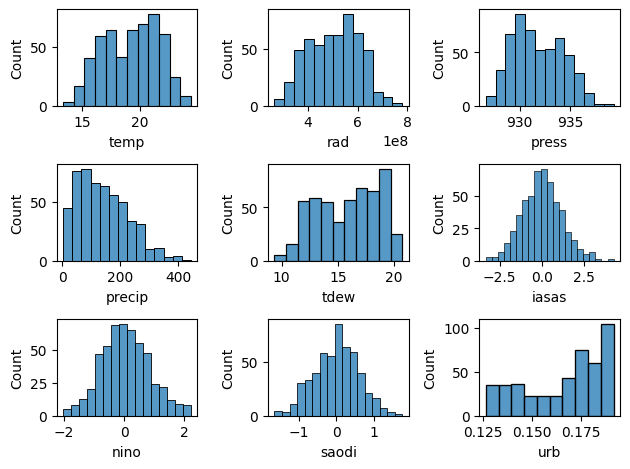

In [57]:
# Histogramas
names = df.columns
fig, axes = plt.subplots(3,3)
for name, ax in zip(names, axes.flatten()):
    #sns.boxplot(y=name, data=df, notch=True, ax=ax)
    sns.histplot(data=df, x=name, ax=ax)
plt.tight_layout()

Correlações

In [58]:
#sns.pairplot(df)

<Axes: >

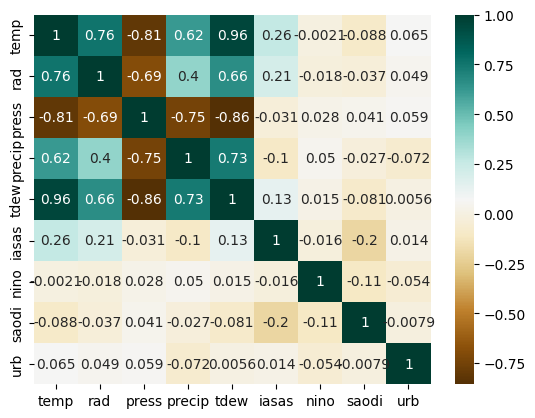

In [59]:
sns.heatmap(df.corr(), annot=True, cmap='BrBG')

Estacionariedade e autocorrelação

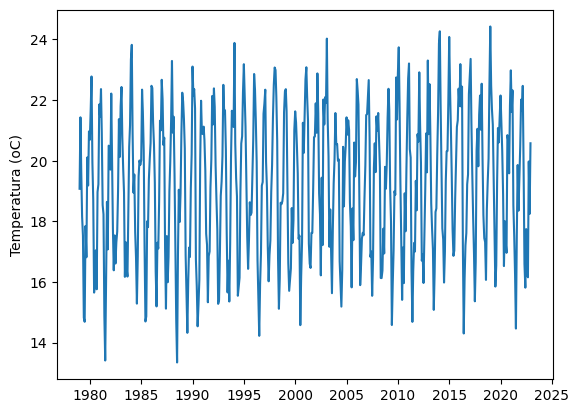

In [60]:
# Série temporal
plt.plot(df.index, df.temp)
plt.ylabel('Temperatura (oC)')
plt.show()

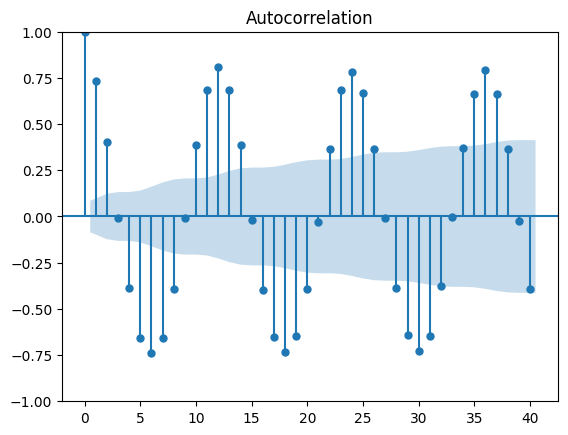

In [61]:
# Função de autocorrelação (ACF)
sm.graphics.tsa.plot_acf(df.temp, lags=40)
plt.show()

Como é a sazonalidade das varáveis?

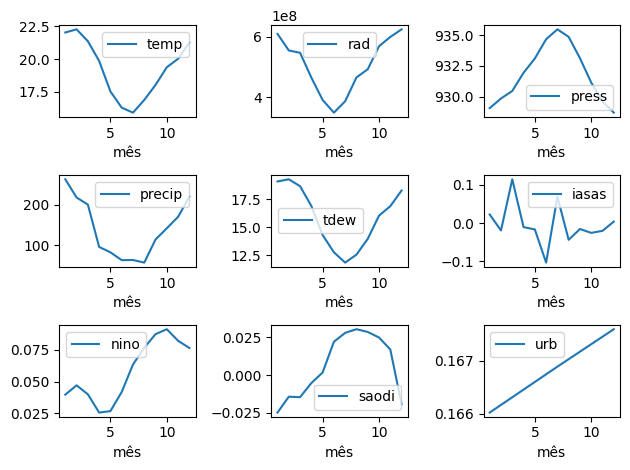

In [62]:
# Calculando a média para cada mês do ano
df_seasonal = df.groupby(df.index.month).mean()
names = df.columns
df_seasonal.index.name = 'mês'
fig, axes = plt.subplots(3,3)
for name, ax in zip(names, axes.flatten()):
    df_seasonal.plot(y=name, ax=ax)
plt.tight_layout()

Há tendências nas variáveis?

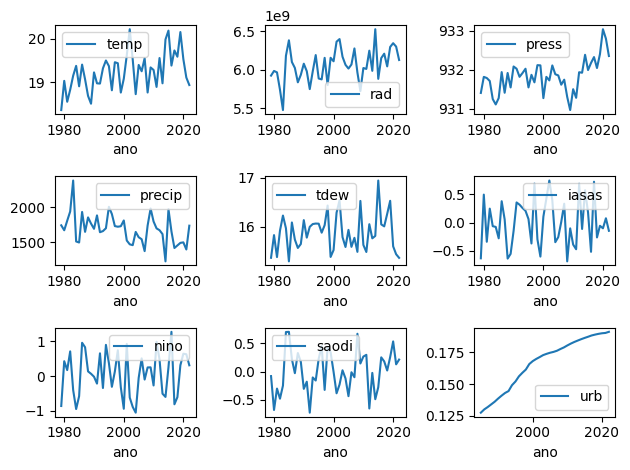

In [63]:
# Médias anuais para cada mês do ano
df_anual = df.groupby(df.index.year).mean()
df_anual.rad = df.rad.groupby(df.index.year).sum()
df_anual.precip = df.precip.groupby(df.index.year).sum()
names = df.columns
df_anual.index.name = 'ano'
fig, axes = plt.subplots(3,3)
for name, ax in zip(names, axes.flatten()):
    df_anual.plot(y=name, ax=ax)
plt.tight_layout()

Há tendência significativa (p<0.05) para: press, precip, urb

In [64]:
# Há tendências significativas?
!pip install pymannkendall

In [65]:
# Teste de Mann Kendall
# Ho(Accepted): There is no trend present in the data (p>0.05)
# Ha(Rejected): A trend is present in the data (p<0.05)
import pymannkendall as mk
mk.original_test(df.precip)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.03343918294934323, z=-2.126770182158189, Tau=-0.061914208498648725, s=-8614.0, var_s=16400903.333333334, slope=-0.05121293800539083, intercept=141.4946091644205)

Função de covariância cruzada

Lag correspondente à máxima correlação:
6


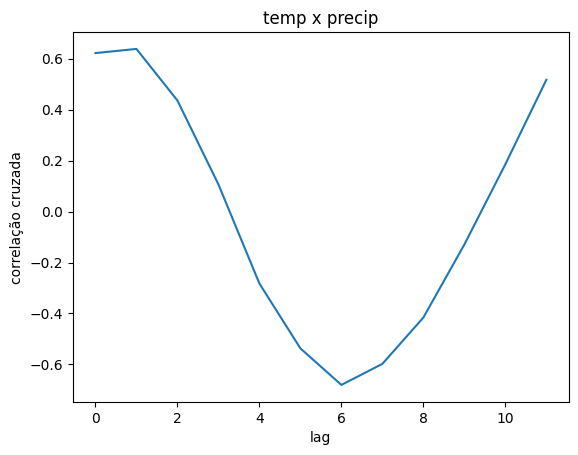

In [66]:
import statsmodels.tsa.stattools as smt
# A função ccf desloca a variável A para frente
A = 'temp'
B = 'precip'
forwards = smt.ccf(df[A], df[B], adjusted=True, nlags=12)
forwards = pd.DataFrame({'lag':np.arange(len(forwards)), 'value':forwards})

print('Lag correspondente à máxima correlação:')
print(forwards.lag.iloc[forwards.value.abs().idxmax()])

plt.plot(forwards.lag, forwards.value)
plt.ylabel('correlação cruzada')
plt.xlabel('lag')
plt.title(A+' x '+ B)
plt.show()

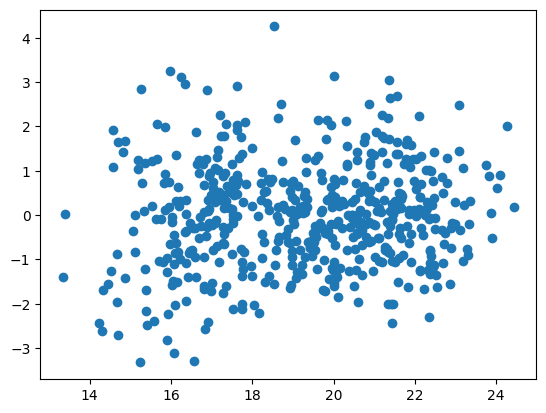

In [68]:
plt.scatter(df.temp,df.iasas.shift(1))

# Preparação dos dados

Escalonar as variáveis

In [81]:
# Escalonando as variáveis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
scaler = StandardScaler()
dfs = pd.DataFrame(scaler.fit_transform(df))
dfs.index = df.index
dfs.columns = df.columns
dfs.head()

,temp,rad,press,precip,tdew,iasas,nino,saodi,urb
datetime,,,,,,,,,
1979-01-01,-0.067767,0.989713,-1.156135,0.247640,0.202213,-2.079894,-1.973320,0.808047,NaN
1979-02-01,0.920313,0.563222,-1.364468,0.075066,0.966777,-0.154082,-1.737242,-0.029702,NaN
1979-03-01,0.185329,0.509972,-0.512846,1.029978,0.444920,-1.883204,-1.513589,0.641178,NaN
1979-04-01,-0.452439,-0.624230,-0.089989,-0.235569,-0.073292,-1.808475,-1.538439,0.625853,NaN
1979-05-01,-0.715591,-1.100458,-0.132645,-0.143529,-0.621023,1.215397,-1.401762,-0.049964,NaN


# ML regressão múltipla

Vamos usar a terminação 'reg' no nome das variáveis, para armazenar os resultados utilizando essa abordagem.

In [70]:
dfs_reg=dfs.copy()

Criação de preditores

In [71]:
# Como os dados apresentam forte sazonalidade, o mês pode ser um preditor importante
# Extraindo o mês do índice datetime
dfs_reg['mes'] = dfs_reg.index.month
# Criando uma variável cíclica
dfs_reg['mes_cos'] = np.cos(2*np.pi*dfs_reg['mes']/12)

# Vamos criar também algumas variáveis defasadas
dfs_reg['precip_6'] = dfs_reg['precip'].shift(6)
dfs_reg['nino_9'] = dfs_reg['nino'].shift(9)
dfs_reg.head()

,temp,rad,press,precip,tdew,iasas,nino,saodi,urb,mes,mes_cos,precip_6,nino_9
datetime,,,,,,,,,,,,,
1979-01-01,-0.067767,0.989713,-1.156135,0.247640,0.202213,-2.079894,-1.973320,0.808047,NaN,1,8.660254e-01,NaN,NaN
1979-02-01,0.920313,0.563222,-1.364468,0.075066,0.966777,-0.154082,-1.737242,-0.029702,NaN,2,5.000000e-01,NaN,NaN
1979-03-01,0.185329,0.509972,-0.512846,1.029978,0.444920,-1.883204,-1.513589,0.641178,NaN,3,6.123234e-17,NaN,NaN
1979-04-01,-0.452439,-0.624230,-0.089989,-0.235569,-0.073292,-1.808475,-1.538439,0.625853,NaN,4,-5.000000e-01,NaN,NaN
1979-05-01,-0.715591,-1.100458,-0.132645,-0.143529,-0.621023,1.215397,-1.401762,-0.049964,NaN,5,-8.660254e-01,NaN,NaN


Seleção de preditores

In [72]:
# Descartando a variável 'urb', que possui muitos valores faltantes
dfs_reg.drop(['urb'], axis=1, inplace=True)
# As variáveis com defasagem geraram linhas com NaN, que deve ser removidas
dfs_reg.dropna(axis=0, how='any', inplace=True)

In [73]:
Xreg = dfs_reg.drop(['temp'], axis=1)
yreg = dfs_reg.temp

Particionamento treino/teste

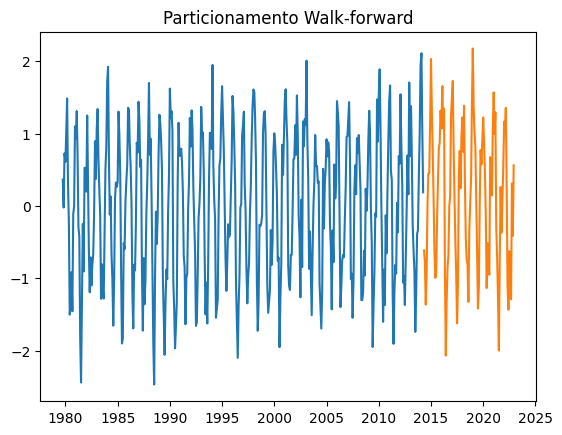

In [74]:
from sklearn.model_selection import TimeSeriesSplit

# Divisão que mantém a ordem das observações
ts_cv = TimeSeriesSplit(n_splits=2, test_size=round(0.2*len(yreg)))
for train_index, test_index in ts_cv.split(Xreg):
    Xreg_train, Xreg_test = Xreg.iloc[train_index, :], Xreg.iloc[test_index,:]
    yreg_train, yreg_test = yreg.iloc[train_index], yreg.iloc[test_index]

# Gráfico para visualizar o particionamento
plt.plot(yreg_train, label='Treino')
plt.plot(yreg_test, label='Teste')
plt.title('Particionamento Walk-forward')
plt.show()

Regressão múltipla com Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor
regRF = RandomForestRegressor()
regRF.fit(Xreg_train, yreg_train)
yreg_pred_train = regRF.predict(Xreg_train)
yreg_pred_test = regRF.predict(Xreg_test)

In [76]:
# Métricas de desempenho - conjunto de teste
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Métricas de desempenho (conjunto de teste) - Regressão Random Forest sem otimização')
print('R^2 = ', r2_score(yreg_test, yreg_pred_test))
print('MSE = ', mean_squared_error(yreg_test, yreg_pred_test))
print('MAE = ', mean_absolute_error(yreg_test, yreg_pred_test))

Métricas de desempenho (conjunto de teste) - Regressão Random Forest sem otimização
R^2 =  0.9363181143421819
MSE =  0.06104238781753257
MAE =  0.18518929649863278


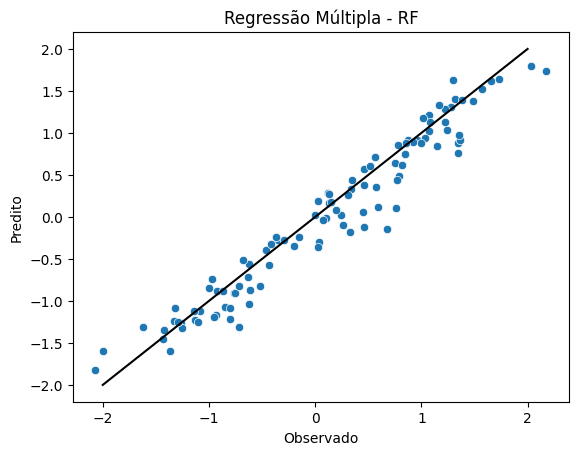

In [77]:
# Plot predito x verdadeiro (conjunto de teste)
fig=sns.scatterplot(x=yreg_test, y=yreg_pred_test)
plt.xlabel('Observado')
plt.ylabel("Predito")
plt.title('Regressão Múltipla - RF')
plt.plot([-2,2], [-2,2], color='black')
plt.show()

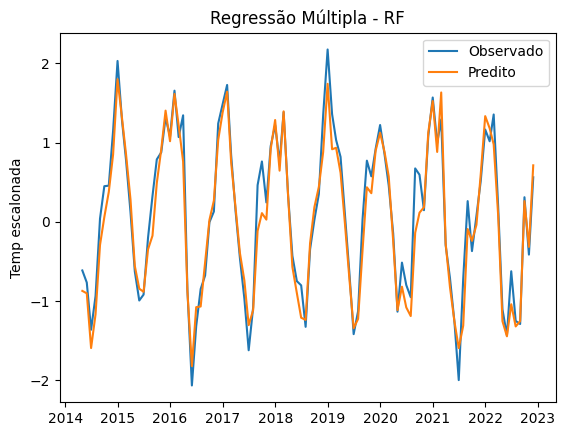

In [78]:
yreg_pred_test = pd.DataFrame(yreg_pred_test)
yreg_pred_test.index = yreg_test.index
plt.plot(yreg_test, label='Observado')
plt.plot(yreg_pred_test, label='Predito')
plt.ylabel("Temp escalonada")
plt.title('Regressão Múltipla - RF')
plt.legend()
plt.show()

# SARIMA Temperatura

Recuperando o resultado do melhor modelo SARIMA da aula passada (predição univariada)

In [79]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model2=ARIMA(yreg_train,order=(1,0,0),seasonal_order=(1,0,1,12))
model2_fit = model2.fit()

# Aplicando o modelo aos dados de treino
start = len(yreg_train)
end = len(yreg_train) + len(yreg_test) - 1
predictions = model2_fit.predict(start=start, end=end, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


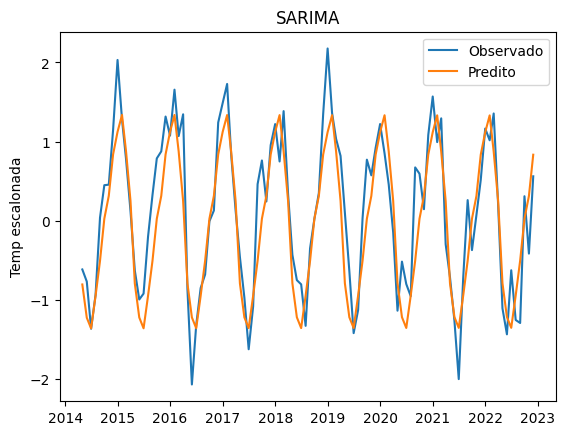

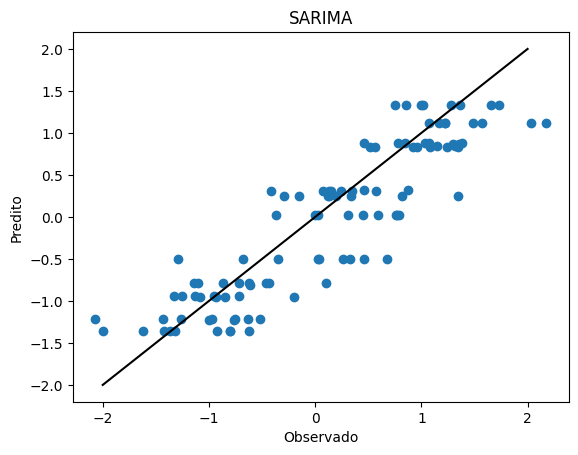

Métricas de desempenho
R^2 =  0.7808629338632036
MSE =  0.21005423501740156
MAE =  0.3641531248112733


In [80]:
# Comparando valores observados e preditos
plt.plot(yreg_test, label='Observado')
plt.plot(predictions, label='Predito')
plt.ylabel("Temp escalonada")
plt.title('SARIMA')
plt.legend()
plt.show()

plt.scatter(yreg_test, predictions)
plt.plot([-2,2], [-2,2], color='black')
plt.xlabel('Observado')
plt.ylabel("Predito")
plt.title('SARIMA')
plt.show()

# Métricas de desempenho
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Métricas de desempenho')
print('R^2 = ', r2_score(yreg_test, predictions))
print('MSE = ', mean_squared_error(yreg_test, predictions))
print('MAE = ', mean_absolute_error(yreg_test, predictions))

Exercício:
*   Testar diferentes subconjuntos de preditores no modelo de regressão múltipla
*   Treinar uma rede neural perceptron e comparar o desempenho com random forest
*   (desafio) Utilizando como base os notebooks da Aula 18, contruir uma rede neural recursiva LSTM para fazer uma predição univariada




